##### Importacion de librerias

In [1]:
import time
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (5,5)

# Ejercicio 1

#### Periodo

In [2]:
print(2**64)

18446744073709551616


#### Generador XORShift

In [3]:
class XORShiftGenerator:

  PERIOD = (2**64) 
 
  def __init__(self,external_seed):
    self.seed = external_seed % self.PERIOD
    
  #funcion para generar un numero pseudo-aleatorio
  def random(self):
    seed_tuple = (23,13,58)
    self.seed = (self.seed ^ (self.seed << seed_tuple[0])) % self.PERIOD
    self.seed = (self.seed ^ (self.seed >> seed_tuple[1])) % self.PERIOD
    self.seed = (self.seed ^ (self.seed << seed_tuple[2])) % self.PERIOD
    return self.seed
 
  #funcion para generar un numero pseudo-aleatorio entre 0 y 1
  def uniform_random(self):
    return self.random() / self.PERIOD

In [4]:
generator = XORShiftGenerator(int(time.time()))

#### Generamos 1000 numeros usando el generador

In [5]:
generated = []
uniform_generated = []

for i in range(1000):
    generated.append(generator.random())

for i in range(1000):
    uniform_generated.append(generator.uniform_random())

In [6]:
generated

[10390261539366283044,
 8992267662680112513,
 7577756621173932988,
 16062257323424172226,
 9906543253061594152,
 9908573441504066067,
 5155481712149457874,
 13059773636766119509,
 275429940118385136,
 12019106626399460331,
 5130271664816600897,
 10797554619561444968,
 13701081358404716764,
 12507991753978579800,
 13898780528335831068,
 5247868502333842570,
 1175094377757433861,
 5073252295079684694,
 630964085934781201,
 1143923696106583630,
 14328224768445065955,
 17256844699875847706,
 4182867414117091183,
 6207884448350794595,
 562711456786533268,
 7249991903647038970,
 14712783945194954573,
 3881879469925357599,
 2744170316553300573,
 16760619659695559928,
 14640706638659307600,
 13560587431734757310,
 15723092626537434836,
 5335389895339484234,
 7905757958670238483,
 7258960337974409501,
 5721318089342366196,
 3873263067322725329,
 5422745879734811800,
 13080667336146451179,
 14133127482460714600,
 1759824476205006181,
 11288655349370138752,
 2724906491467327657,
 1152665517189236

#### Y estudiamos los resultados mediante graficos

Con este grafico facilmente se aprecia como es la distribucion de los valores generados. Vemos que no se presenta una acumulacion en un sector especifico, sino que estan bastante repartidos.

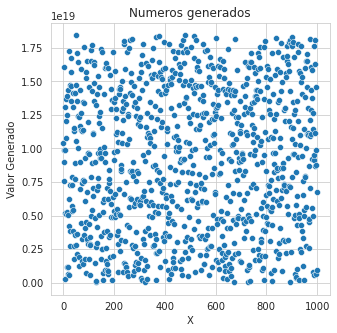

In [7]:
sns.scatterplot(data=generated)
plt.title("Numeros generados")
plt.xlabel("X")
plt.ylabel("Valor Generado")
plt.show()

Si contabilizamos entonces cuantos puntos caen en cada intervalo, vemos que no se presentan grandes diferencias en cada uno de ellos.

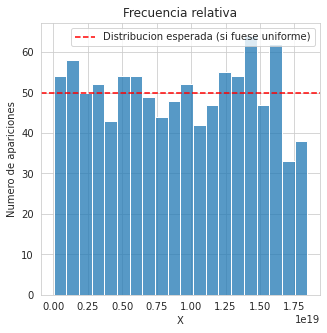

In [8]:
sns.histplot(data=generated,bins=20)
plt.axhline(
    y=1000 / 20,
    xmin=0,
    xmax=1,
    color="r",
    linestyle="--",
    label="Distribucion esperada (si fuese uniforme)",
)
plt.title('Frecuencia relativa')
plt.xlabel("X")
plt.ylabel("Numero de apariciones")

plt.legend()
plt.show()

#### Ahora ilustremos los valores generados entre 0 y 1

Misma distribucion de puntos, pero ahora vemos que solo se toman valores entre 0 y 1.

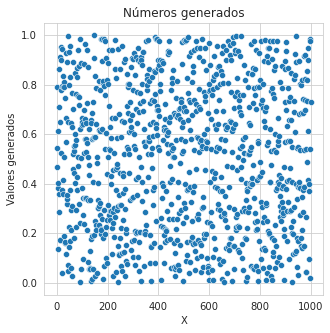

In [9]:
sns.scatterplot(data=uniform_generated)
plt.title('Números generados')
plt.ylabel("Valores generados")
plt.xlabel("X")
plt.show()

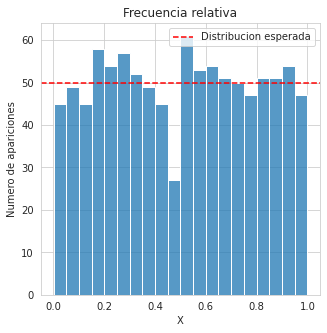

In [10]:
sns.histplot(data=uniform_generated,bins=20)
plt.title('Frecuencia relativa')
plt.ylabel("Numero de apariciones")
plt.xlabel("X")
plt.axhline(
    y=1000 / 20,
    xmin=0,
    xmax=1,
    color="r",
    linestyle="--",
    label="Distribucion esperada",
)
plt.legend()
plt.show()

# Ejercicio 6.1

#### Generador GCL (Concruencial Lineal)

In [11]:
class GCL:
    # datos provistos
    
    # modulo
    m = 2**32
    
    # multiplicador
    a = 1013904223

    # incremento
    c = 1664525
    
    def __init__(self,seed):
        self.xn = seed
        
    def random(self):
        self.xn = (self.xn*self.a + self.c) % self.m
        return self.xn

    def uniform_random(self):
        return self.random() / self.m

In [12]:
# parte entera del promedio de los padrones
seed = int((99289 + 96453 + 100853 + 97839 )/4)
gcl_generator = GCL(seed) 

#### Generamos 1000 numeros usando el generador

In [13]:
gcl_generated = []
gcl_uniform_generated = []
for i in range(1000):
    gcl_generated.append(gcl_generator.random())
    gcl_uniform_generated.append(gcl_generator.uniform_random())

#### Y estudiamos los resultados mediante graficos

Vemos rapidamente con el scatterplot que la densidad de puntos se expresa de la misma manera en ambos generadores.

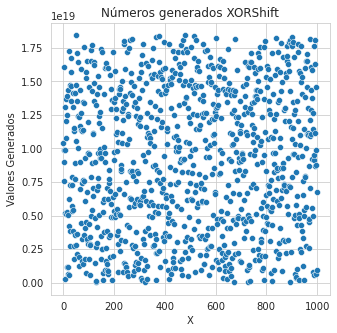

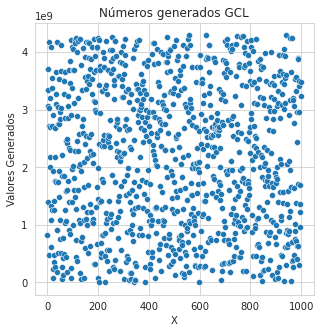

In [14]:
sns.scatterplot(data=generated)
plt.title('Números generados XORShift')
plt.xlabel("X")
plt.ylabel("Valores Generados")
plt.show()

sns.scatterplot(data=gcl_generated)
plt.title('Números generados GCL')
plt.xlabel("X")
plt.ylabel("Valores Generados")
plt.show()

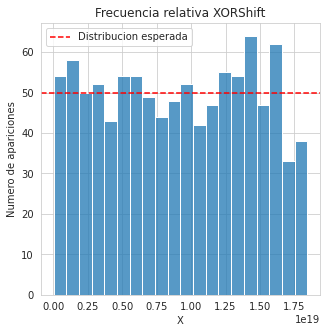

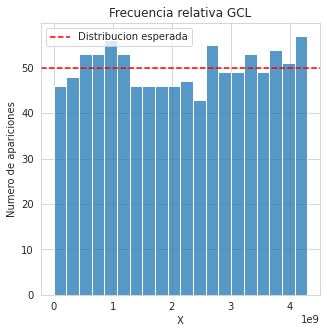

In [15]:
sns.histplot(data=generated,bins=20)
plt.title('Frecuencia relativa XORShift')
plt.xlabel("X")
plt.ylabel("Numero de apariciones")
plt.axhline(
    y=1000 / 20,
    xmin=0,
    xmax=1,
    color="r",
    linestyle="--",
    label="Distribucion esperada",
)
plt.legend()
plt.show()

sns.histplot(data=gcl_generated,bins=20)
plt.title('Frecuencia relativa GCL')
plt.xlabel("X")
plt.ylabel("Numero de apariciones")
plt.axhline(
    y=1000 / 20,
    xmin=0,
    xmax=1,
    color="r",
    linestyle="--",
    label="Distribucion esperada",
)
plt.legend()
plt.show()

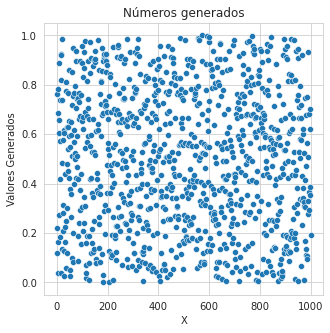

In [16]:
sns.scatterplot(data=gcl_uniform_generated)
plt.title('Números generados')
plt.xlabel("X")
plt.ylabel("Valores Generados")
plt.show()

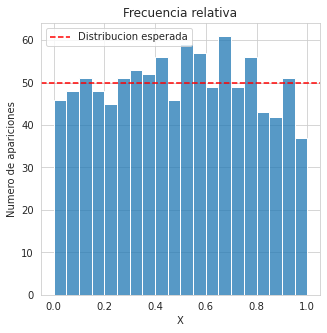

In [17]:
sns.histplot(data=gcl_uniform_generated,bins=20)
plt.axhline(
    y=1000 / 20,
    xmin=0,
    xmax=1,
    color="r",
    linestyle="--",
    label="Distribucion esperada",
)
plt.title('Frecuencia relativa')
plt.xlabel("X")
plt.ylabel("Numero de apariciones")
plt.legend()
plt.show()

# Ejercicio 2

### Test de Kolmogorov

In [18]:
from scipy.stats import kstest

generator = XORShiftGenerator(int(time.time()))

def generate_sample(longitud):
    sample = []
    for i in range(longitud):
        sample.append(generator.uniform_random())
    return sample

def kol_test_sample(sample):
    tested = kstest(sample, 'uniform')
    if tested[1] >= 0.05:
        print("El test acepta la hipotesis nula.")
    else:
        print("El test rechaza la hipótesis nula")
    print("Estadistico: {:.4f} ".format(tested[0]))
    print("P Valor: {:.4f} ".format(tested[1]))

In [19]:
big_sample = generate_sample(10000)
kol_test_sample(big_sample)

El test acepta la hipotesis nula.
Estadistico: 0.0093 
P Valor: 0.3462 


In [20]:
small_sample = generate_sample(1000)
kol_test_sample(small_sample)

El test acepta la hipotesis nula.
Estadistico: 0.0316 
P Valor: 0.2662 


In [21]:
def gcl_generate_sample(longitud):
    sample = []
    for i in range(longitud):
        sample.append(gcl_generator.uniform_random())
    return sample

In [22]:
gcl_big_sample = gcl_generate_sample(10000)
kol_test_sample(gcl_big_sample)

El test rechaza la hipótesis nula
Estadistico: 0.0175 
P Valor: 0.0043 


In [23]:
gcl_small_sample = gcl_generate_sample(1000)
kol_test_sample(gcl_small_sample)

El test acepta la hipotesis nula.
Estadistico: 0.0239 
P Valor: 0.6092 


### Test 2

### Test 3

# Ejercicio 3

In [24]:
# genexp genera un valor de una variable Exp(lam) utilizando equivalencia de eventos contra una uniforme (0,1)
# ver: pag.4 de https://campusgrado.fi.uba.ar/pluginfile.php/29915/mod_page/content/419/Te%C3%B3rica%204%20Generaci%C3%B3n%20de%20variables%20continuas%20y%20discretas.pdf
def genexp(u, lam=1):
    return -np.log(1-u) / lam

def normalpdf(x, mu=0, sigma=1):
    var = np.square(sigma)
    return np.exp(-np.square(x - mu) / (2 * var)) / np.sqrt(2 * np.pi * var)
def exppdf(x, lam=1):
    return lam * np.exp(-lam * x)

# gennorm genera valores de una normal de media "mu" y desviación "sigma", utilizando un metodo de aceptación rechazo contra una variable Exp(1)
# ver: pag.9 de https://campusgrado.fi.uba.ar/pluginfile.php/29915/mod_page/content/419/Te%C3%B3rica%204%20Generaci%C3%B3n%20de%20variables%20continuas%20y%20discretas.pdf
def gennorm(N, mu=0, sigma=1):
    c = np.sqrt(2 * np.e / np.pi)
    t = np.array([genexp(generator.uniform_random()) for _ in range(N)])

    # probabilidad de aceptar
    p = normalpdf(t) / (c * exppdf(t))

    z = np.array([])
    for i in range(N):
        if generator.uniform_random() < p[i]:
            r2 = generator.uniform_random()
            val = t[i] if r2 < 0.5 else -t[i]
            z = np.concatenate((z, [sigma * val + mu]))

    return z

[Text(0.5, 0, 'Nros pseudoaleatorios'), Text(0, 0.5, 'Frecuencia')]

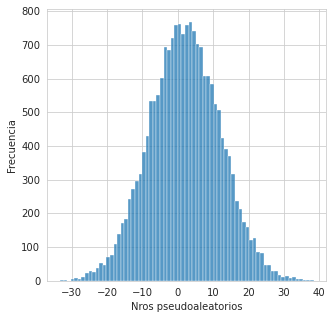

In [25]:
# Generamos una muestra de N=10000 y graficamos el histograma
N=50000

mu = 2.0
sigma = 10.0

data = gennorm(N, mu, sigma)
sns.histplot(data=data).set(xlabel="Nros pseudoaleatorios",ylabel="Frecuencia")

## Tests Estadísticos

In [26]:
from scipy.stats import kstest, shapiro, norm

def cdf(x):
    return norm.cdf(x, loc=mu, scale=sigma)

alfa = 0.05

### Test 1: Kolmogorov-Smirnov

In [27]:
K, pv = kstest(data, cdf)

print("K = %f, p-val = %f" % (K, pv))
print("Existe evidencia para rechazar que los datos no siguen una distribución normal (2,10)" if pv < alfa else "No existe evidencia para afirmar que los datos no se distribuyen de forma normal (2, 10)")

K = 0.003167, p-val = 0.990999
No existe evidencia para afirmar que los datos no se distribuyen de forma normal (2, 10)


### Test 2: Shapiro-Wilk

In [28]:
sorted_data = np.sort(data)

S, pv = shapiro(sorted_data)

print("S = %f, p-val = %f" % (S, pv))
print("Existe evidencia para rechazar que los datos no siguen una distribución normal (2,10)" if pv < alfa else "No existe evidencia para afirmar que los datos no se distribuyen de forma normal (2, 10)")

S = 0.999877, p-val = 0.445995
No existe evidencia para afirmar que los datos no se distribuyen de forma normal (2, 10)


/home/ale/anaconda3/lib/python3.9/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


# Ejercicio 4

La llegada de vehiculos a un estacionamiento sigue un proceso de Poisson de tasa lamda vehiculos/hora.

In [29]:
import pandas as pd

In [30]:
tiempo_entre_arribos = pd.read_csv('tiempos_entre_arribos.txt', header=None)

In [31]:
tiempo_entre_arribos

,0
0,0.028390
1,0.294435
2,0.048560
3,0.140468
4,0.023268
...,...
9995,0.216236
9996,0.099258
9997,0.163479
9998,0.121538


#### Estimacion de la tasa de arribos

In [32]:
cantidad_arribos = len(tiempo_entre_arribos)
cantidad_arribos

10000

In [33]:
tiempo_total = tiempo_entre_arribos[0].sum()
tiempo_total

1.0111994386169151e+03

In [34]:
lambda_ = cantidad_arribos / tiempo_total
lambda_

9.889245996494685

#### Simulacion de llegada de vehiculos con generador XorShift

In [35]:
# cantidad de arribos
n = 10

# arribos
arribos = []

arribo = 0

generator = XORShiftGenerator(int(time.time()))

# 1 mes en horas
mes = 24 * 30

while arribo < mes:
    # tiempo en horas
    z = genexp(generator.uniform_random(), lam=lambda_)
    arribo = arribo + z
    arribos.append(arribo)

In [36]:
print("Cantidad de arribos en un mes: " + str(len(arribos)))

Cantidad de arribos en un mes: 7215


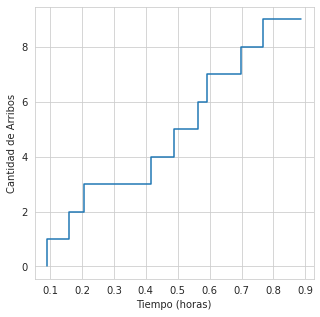

In [37]:
plt.step(arribos[0:10], range(len(arribos[0:10])))
plt.xlabel('Tiempo (horas)')
plt.ylabel('Cantidad de Arribos')
plt.show()

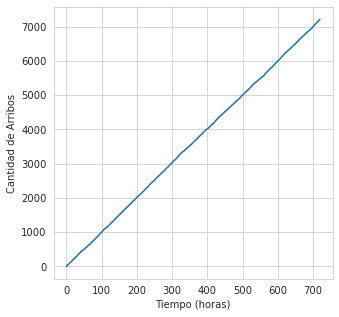

In [38]:
plt.step(arribos, range(len(arribos)))
plt.xlabel('Tiempo (horas)')
plt.ylabel('Cantidad de Arribos')
plt.show()

#### Generacion 1000 arribos con el proceso de Poisson

In [39]:
# cantidad de arribos
n = 1000

# arribos
arribos = []

arribo = 0

for i in range(n):
    z = np.random.exponential(1/lambda_)
    arribo = arribo + z
    arribos.append(arribo)

In [40]:
arribos

[0.21021770109881224,
 0.2201049620882984,
 0.2539288132307522,
 0.26756328125122575,
 0.6146795947644175,
 0.8352585311865299,
 0.9796071138139706,
 1.0614213426972041,
 1.0617148072887173,
 1.156194193404852,
 1.2452071018069109,
 1.307989179740803,
 1.5798949171404224,
 1.5801142803302306,
 1.7445154269919307,
 1.8619315706905113,
 1.9202592510876917,
 1.9595741528666633,
 2.0360035014462077,
 2.241751143701027,
 2.243057986250818,
 2.4279982270383003,
 2.466002323628326,
 2.5008861879105453,
 2.583297043457277,
 2.618469220387375,
 2.7050669467548483,
 2.9379788621089844,
 2.9999351480132117,
 3.0747998956550955,
 3.1755686338362326,
 3.2902825738668073,
 3.3081774873326353,
 3.51000357729876,
 3.6771539662943082,
 3.7216825034684216,
 3.7720208144022878,
 3.8160596149136836,
 3.9646210342310972,
 4.391447798339359,
 4.674309304669278,
 4.677009961282766,
 4.697987847031981,
 4.860604717869386,
 5.068045392159267,
 5.0745983686375125,
 5.180980091631358,
 5.465807796726512,
 5.5181

#### Probabilidad de que el primer vehiculo arribe antes de los 10 minutos 

Paso 10 minutos a horas. 10 -> 10 / 60 = 0.16

\begin{equation}
P(X_1 < 0.16) = 1 - P(X_1 > 0.16)
\end{equation}

Prababilidad de que el primer arribo sea despues de los 10 minutos, es lo mismo que pedir que durante los primeros 10 minutos no haya arribos

\begin{equation}
P(X_1 > 0.16) = P(N_{(0, 0.16]} = 0)
\end{equation}

\begin{equation}
P(N_{(s,t]}=x) = \frac{e^{-\lambda (t-s)} (\lambda (t-s))^x }{x!}
\end{equation}

\begin{equation}
P(N_{(0,0.16]}=0) = \frac{e^{-\lambda 0.16} (\lambda 0.16)^0 }{0!}
\end{equation}

Tomando que los tiempos entre arribos son en horas. Tenemos que t es (10 * 100) / 60 = 16.6666666667

In [52]:
import math
from decimal import Decimal
def prob(t, x, lambda_):
    numerador = Decimal(math.e ** (-(lambda_ * t))) * Decimal((lambda_ * t) ** x) 
    denominador =  Decimal(math.factorial(x))
    return numerador / denominador

In [53]:
1 - prob(0.16, 0, lambda_)

Decimal('0.7944938584160514682963594169')

Por lo tanto la probabilidad pedida practicamente un 80%.

#### Probabilidad de que el undecimo vehiculo arribe despues de los 60 minutos

Paso a horas. 60 min -> 1 h

\begin{equation}
P(X_{11} > 1)
\end{equation}

Esto es lo mismo que pedir que hasta 1 hora, haya <= 10 arribos.

\begin{equation}
P(N_{(0,1]} <= 10) = \sum\limits_{i=0}^{10} P(N_{(0,1]} = i)
\end{equation}

In [54]:
sum_ = 0
for i in range(10):
    sum_ = sum_ + prob(1, i, lambda_)
sum_

Decimal('0.4718605839507911811042944227')

#### Probabilidad de que arriben al menos 750 vehiculos antes de las 72 horas

Esto es lo mismo que pedir que hasta 72 horas, haya < 750 arribos.

\begin{equation}
P(N_{(0,72]} < 750) = \sum\limits_{i=0}^{750} P(N_{(0,72]} = i)
\end{equation}

In [58]:
from decimal import Decimal
sum_ = 0
for i in range(750):
    print(i, prob(72, i, lambda_))
    sum_ = sum_ + prob(72, i, lambda_)
sum_

0 5.904218412121533987483544380E-310
1 4.203955317204221878533636275E-307
2 1.496662138443758181860331954E-304
3 3.552206414570426019426857722E-302
4 6.323155751522397797602619333E-300
5 9.004498948937550175532083967E-298
6 1.068572462174655065849875457E-295
7 1.086930097048303774540634553E-293
8 9.674027199634064528485417790E-292
9 7.653506780316948777579766744E-290
10 5.449493612620389597348555514E-288
11 3.527435971081934095204261637E-286
12 2.093020923294801123503514658E-284
13 1.146372855855104564441765993E-282
14 5.830335347274138814939762199E-281
15 2.767565783580106491851741863E-279
16 1.231611248038735966341475741E-277
17 5.158463973418542122554802995E-276
18 2.040532767887654968628407740E-274
19 7.646904191576542412031725174E-273
20 2.722396199836562624565635792E-271
21 9.230552818322081260153276299E-270
22 2.987450427404433775615900262E-268
23 9.248441377753762886696447665E-267
24 2.743803356063015327810236151E-265
25 7.814634149985077998603449546E-264
26 2.14008478565013886

/tmp/ipykernel_49644/4054803197.py:4: RuntimeWarning: overflow encountered in double_scalars
  numerador = Decimal(math.e ** (-(lambda_ * t))) * Decimal(((lambda_ * t) ** x))


Decimal('Infinity')